1: load in the dataset and libraries

In [26]:
import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import math
import itertools

image = cv.imread('blok.jpg')


conversion algorithms

841 79


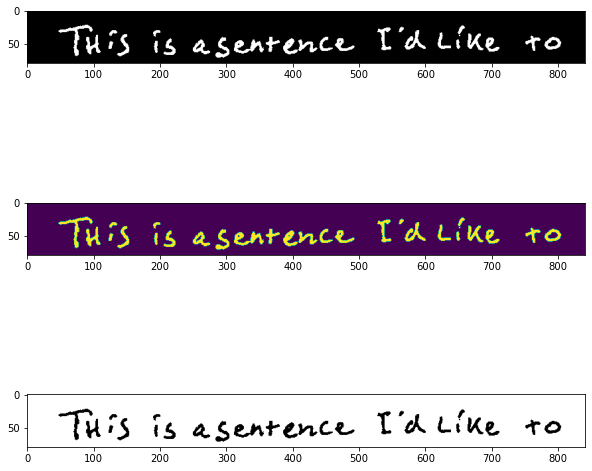

In [27]:
def rgb_to_bin(rgb):
    s = 0
    for i in range(3):
        s += rgb[i]
    #if (s / 3) < 128 #messy images are workable
    if (s / 3) < 254: #anything not white goes through, only for digital paper
        return 0
    else:
        return 1
    
def rgb_to_abs(rgb):
    s = 0
    for i in range(3):
        s += rgb[i]
    #if (s / 3) < 128 #messy images are workable
    if (s / 3) < 254: #anything not white goes through, only for digital paper
        return 0
    else:
        return 255
    
def simplify(img):
    w,h = img.shape[:2]
    #out = [] 
    out = np.zeros(img.shape[:2])
    #print(out)
    for x in range(w):
        #line = []
        for y in range(h):
            #line.append(rgb_to_bin(img[x][y]))
            out[x][y] = rgb_to_bin(img[x][y])
        #out.append(line)
    return out

def absoluteCVGray(cvimg):
    gray = cv.cvtColor(cvimg, cv.COLOR_BGR2GRAY)
    h, w = cvimg.shape[:2]
    print(w, h)
    #print(len(cvimg[0]))
    for y in range(h):
        for x in range(w):
            gray[y][x] = rgb_to_abs(cvimg[y][x])       
    return gray

def showImages(imgs):
    fig, axes = plt.subplots(len(imgs), 1, figsize=(10, 10))
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])
    plt.plot()

def invert(image):
    return (255-image)

cvimage = cv.imread("line_0.png")
#print(cvimage.shape[:2])
imgray = cv.cvtColor(cvimage, cv.COLOR_BGR2GRAY)
invgray = invert(cvimage)
absgray = absoluteCVGray(cvimage)

showImages([cvimage, imgray, invgray])

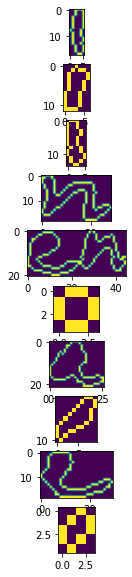

In [43]:
#turns the contour into an image

def getBounds(cnt):
    minx = 100000
    maxx = 0
    miny = 100000
    maxy = 0
    for c in cnt:
        point = c[0]
        x = point[0]
        y = point[1]
        if x < minx:
            minx = x
        if x > maxx:
            maxx = x
        if y < miny:
            miny = y
        if y > maxy:
            maxy = y
    return [(maxy - miny) + 1, (maxx - minx) + 1, minx, miny, maxx, maxy]

def printBounds(b):
    print('size of bounds = ', b[0], 'by', b[1])

def sqdist(x1, y1, x2, y2):
    return np.square(x2 - x1) + np.square(y2 - y1)

#assumes that distance is a square
def blob(canvas, point, dist, fill):
    h, w = canvas.shape[:2]
    xs = point[0] - dist
    ys = point[1] - dist
    xe = point[0] + dist
    ye = point[1] + dist
    if xs < 0:
        xs = 0
    if ys < 0:
        ys = 0
    if xe > w:
        xe = w
    if ye > h:
        ye = h
    for x in range(xs, xe):
        for y in range(ys, ye):
            if sqdist(x,y, point[0], point[1]) <= dist:
                canvas[y][x] = fill

def combineContours(contours, dist = 5):
    #combines contours based on distance between their points
    dsq = np.square(dist)
    out = []
    for cnt1, cnt2 in itertools.combinations(contours, 2):
        copy = cnt1
        print('a = ', cnt1)
        print('b = ', cnt2)
        for c1, c2 in itertools.product(cnt1, cnt2):
            p1 = c1[0]
            p2 = c2[0]
            if sqdist(p1[0], p1[1], p2[0], p2[1]) <= dsq:
                #copy = copy + cnt2
                break
        out.append(copy)
    return out
                            
                        
    
def seperateContours(contours, img, border = 0):
    blocks = []
    h,w = img.shape[:2]
    for cnt in contours:
        b = getBounds(cnt)
        if b[0] == h and b[1] == w:
            continue
        mask = np.zeros(img.shape[:2],np.uint8)
        cv.drawContours(mask, contours, -1, (255), -1)
        block = np.zeros(b[:2])
        for y in range(b[0]):
            for x in range(b[1]):
                block[y][x] = mask[y + b[3]][x + b[2]]
        #potential cleanup
        if (border > 0):
            dsq = np.square(border)
            #apply padding around the contour
            keep = invert(np.zeros(b[:2]))
            for c in cnt:
                point = c[0] - b[2:4]
                blob(keep, point, dsq, 0)
            #cross reference contour with border
            for y in range(b[0]):
                for x in range(b[1]):
                    if keep[y][x] == 255:
                        block[y][x] = 255
        blocks.append(keep)
    return blocks

def getContours(img):
    #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #indications = np.zeros(gray.shape[:2])
    #h, w = gray.shape[:2]
    ret, thresh = cv.threshold(img, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    return contours

def cnt_to_imgs(contours):
    imgs = []
    for cnt in contours:
        b = getBounds(cnt)
        img = np.zeros(b[:2])
        for c in cnt:
            point = c[0] - b[2:4]
            img[point[1]][point[0]] = 255
        imgs.append(img)
    return imgs

def simplify(img, tresh = 200, invert = False):
    h,w = img.shape[:2]
    out = np.zeros([h,w])
    for y in range(h):
        for x in range(w):
            if img[y][x] < tresh:
                out[y][x] = 0
            else:
                out[y][x] = 1
    if invert:
        return (1 - out)
    else:
        return out
    
def expand(img):
    h,w = img.shape[:2]
    out = np.zeros([h,w], np.uint8)
    for y in range(h):
        for x in range(w):
            if img[y][x] == 1:
                out[y][x] == 255
    return out
    
cvi = cv.imread("line_0.png")
#print(cvimage.shape[:2])
gray = cv.cvtColor(cvi, cv.COLOR_BGR2GRAY)
binary = simplify(gray)

contours = getContours(expand(binary))
#print(len(contours))
#imgs = cnt_to_imgs(contours)

showImages(imgs[:10])
#combs = combineContours(contours[:20])
#print(len(combs))
#boxes = seperateContours(contours, imgray, 5)
#padBoxes(boxes)
#showImages(boxes[40:60])

#testbox = boxContour(features[1], invgray)

#showImages([imgray, testbox])

